# Football pass network

This notebook will be used to generate football pass network for a specific match.

## Import packages

In [2]:
import ScraperFC as sfc
import traceback
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from mplsoccer import Pitch, add_image, FontManager, VerticalPitch
from matplotlib.colors import to_rgba
from PIL import Image
from urllib.request import urlopen

## Scrape data from WhoScored

In [3]:
link = 'https://www.whoscored.com/Matches/1558415/Live/France-Ligue-1-2021-2022-Lens-Paris-Saint-Germain'
scraper = sfc.WhoScored()
try:
    match_data = scraper.scrape_match(link)
except:
    traceback.print_exc()
scraper.close()

In [4]:
match_data

{'matchId': 1558415,
 'matchCentreData': {'playerIdNameDictionary': {'330672': 'Facundo Medina',
   '330816': 'Kevin Danso',
   '344645': 'Ignatius Ganago',
   '70291': 'Gaël Kakuta',
   '301869': 'Jonathan Clauss',
   '422136': 'Christopher Wooh',
   '23353': 'Yannick Cahuzac',
   '34182': 'Jean-Louis Leca',
   '118351': 'Corentin Jean',
   '236552': 'Jonathan Gradit',
   '274934': 'Florian Sotoca',
   '384005': 'Arnaud Kalimuendo-Muinga',
   '374993': 'Cheick Oumar Doucouré',
   '339500': 'Przemyslaw Frankowski',
   '94892': 'Massadio Haïdara',
   '283010': 'Wuilker Fariñez',
   '254562': 'Seko Fofana',
   '400193': 'David Costa',
   '403917': 'Charles Boli',
   '414248': 'Jonathan Varane',
   '11119': 'Lionel Messi',
   '23110': 'Ángel Di María',
   '93700': 'Leandro Paredes',
   '106964': 'Mauro Icardi',
   '101949': 'Marquinhos',
   '106590': 'Rafinha',
   '65901': 'Keylor Navas',
   '300713': 'Kylian Mbappé',
   '247800': 'Presnel Kimpembe',
   '248112': 'Abdou Diallo',
   '36128

## Create variables for team names, score and player dictionaries

In this part, we will create variables with general information on the teams, score and players. This will help us in the data visualisation part.

In [27]:
## Get home and away team id and name
home_team = match_data['matchCentreData']['home']['name']
home_id = match_data['matchCentreData']['home']['teamId']

away_team = match_data['matchCentreData']['away']['name']
away_id = match_data['matchCentreData']['away']['teamId']

# Score of the match
score = match_data['matchCentreData']['score']

# Create players dict and dataframes
home_ids = [player['playerId'] for player in match_data['matchCentreData']['home']['players']]
away_ids = [player['playerId'] for player in match_data['matchCentreData']['away']['players']]

players = match_data['matchCentreData']['playerIdNameDictionary']

df_players_home = pd.DataFrame.from_dict(match_data['matchCentreData']['home']['players'])
df_players_away = pd.DataFrame.from_dict(match_data['matchCentreData']['away']['players'])
df_players = pd.concat([df_players_home, df_players_away])

## Data cleaning

Here, we'll clean the dataframe and create another dataframe named df_rel with all the relevant information to create football pass networks.

In [28]:
#Show all the rows and columns from dataframe
pd.set_option('display.max_columns', None)
#Uncomment this line if we want to see all the rows
pd.set_option("max_rows", None) 

df = pd.DataFrame.from_dict(match_data['matchCentreData']['events'])

df_period = pd.json_normalize(df['period'])
df['period'] = df_period['displayName']

df_type = pd.json_normalize(df['type'])
df['type'] = df_type['displayName']

df_outcomeType = pd.json_normalize(df['outcomeType'])
df['outcomeType'] = df_outcomeType['displayName']

#Change teamId to team name
df['teamId'] = df['teamId'].apply(lambda x: home_team if x == home_id else away_team)

### Filter out the columns with only relevant data and add player name, shirt No to df
df_rel = df[['id','eventId','minute','second','teamId','x', 'y', 'period', 'type', 'outcomeType', 'playerId', 'endX', 'endY']]
df_rel = df_rel.merge(df_players[['playerId', 'shirtNo', 'name']], how='left')

### Create a column passer and recipient that will be used when we filter by passes
df_rel['passer'] = df_rel['shirtNo']
df_rel['recipient'] = df_rel['shirtNo'].shift(-1)

df_home = df_rel[df_rel['teamId'] == home_team]
df_away = df_rel[df_rel['teamId'] == away_team]

## Pass network for home team

We will create pass network for the home team. What needs to be changed in the visualisation are the team and competition logos.

In [29]:
### Passes by home team and add players to the dataframe
h_passes = df_home[df_home['type'] == 'Pass']
h_passes['shirtNo'] = h_passes['shirtNo'].astype('int64')
h_passes['passer'] = h_passes['passer'].astype('int64')
h_passes['recipient'] = pd.to_numeric(h_passes['recipient'], downcast = 'integer')

### Filter the successful passes
h_passes_succ = h_passes[h_passes['outcomeType'] == 'Successful']

### Create dataframe with substitution
df_subs_home = df_home[df_home['type'] == 'SubstitutionOff']

### List with the minute of each substitution
subs_home = list(df_subs_home['minute'])

### Limit dataframes to first substitution
h_passes_succ = h_passes_succ[h_passes_succ['minute'] < subs_home[0]]

### Create average locations dataframe grouped by passer
average_locations_home = h_passes_succ.groupby('passer').agg({'x': ['mean'], 'y':['mean', 'count']})
average_locations_home.columns = ['x', 'y', 'count']

### Create pass between players dataframe 
pass_between_home = h_passes_succ.groupby(['passer', 'recipient']).eventId.count().reset_index()
pass_between_home.rename({'eventId':'pass_count'}, axis = 'columns', inplace = True)

### Merge both pass_between and average_location dataframes
pass_between_home = pass_between_home.merge(average_locations_home[['x', 'y']], left_on = 'passer', right_index = True)
pass_between_home = pass_between_home.merge(average_locations_home[['x', 'y']], left_on = 'recipient', right_index = True, suffixes = ("", "_end"))

### Fill in the paramaters wished for the minimum number of passes to take into account
min_nb_passes_home = 4

pass_between_home = pass_between_home[pass_between_home['pass_count'] >= min_nb_passes]

## Merge players name to average_locations dataframe
average_locations_home = average_locations_home.merge(df_players_home['name'], left_on='passer', right_on=df_players_home['shirtNo'])


/var/folders/02/kvdchhy158bcnynphq3prw8h0000gn/T/ipykernel_1070/3825250660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_passes['shirtNo'] = h_passes['shirtNo'].astype('int64')
/var/folders/02/kvdchhy158bcnynphq3prw8h0000gn/T/ipykernel_1070/3825250660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_passes['passer'] = h_passes['passer'].astype('int64')
/var/folders/02/kvdchhy158bcnynphq3prw8h0000gn/T/ipykernel_1070/3825250660.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

You'll find below the data visualisation part.

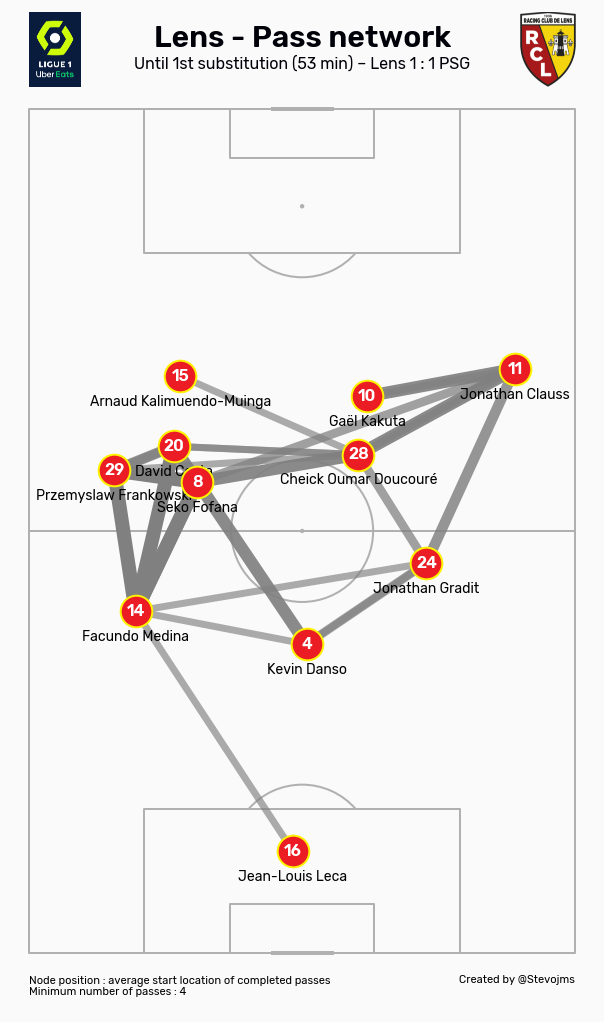

In [53]:
### Data visualisation part

#Setting up line and markers width
MAX_LINE_WIDTH = 14
MAX_MARKER_SIZE = 1500

pass_between_home['width'] = (pass_between_home.pass_count / pass_between_home.pass_count.max() * MAX_LINE_WIDTH)
average_locations_home['marker_size'] = (average_locations_home['count'] / average_locations_home['count'].max() * MAX_MARKER_SIZE)

pass_between = pass_between_home
average_locations = average_locations_home

#Setting up colors to make the line transparent when fewer passes are made

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('grey'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY) + MIN_TRANSPARENCY)
color[:, 3] = c_transparency

#Pitch visualisation

team_color = '#ec1c24' #Fill in the team color
node_edgecolor = '#fff200'
number_color = '#ffffff'

bgcol = '#fafafa' 

URL = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Light.ttf?raw=true'
URL2 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Regular.ttf?raw=true'
URL3 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-SemiBold.ttf?raw=true'

rubik_light = FontManager(URL)
rubik_regular = FontManager(URL2)
rubik_semibold = FontManager(URL3)

#Change image URL if needed
COMPETITION_URL = 'https://upload.wikimedia.org/wikipedia/commons/4/49/Ligue1_Uber_Eats_logo.png'
competition_image = Image.open(urlopen(COMPETITION_URL))

#Change team logo URL if needed
team_logo_URL = 'https://www.rclens.fr/sites/default/files/lens.png' #Team logo
team_logo_image = Image.open(urlopen(team_logo_URL))

pitch = VerticalPitch(pitch_type= 'opta', half=False)
fig, axs = pitch.grid(figheight=14, title_height=0.08, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0, grid_height=0.88, endnote_height=0.04)

fig.set_facecolor(bgcol)
axs['title'].set_facecolor(bgcol)
axs['pitch'].set_facecolor(bgcol)
axs['endnote'].set_facecolor(bgcol)

#pass_arrows = pitch.arrows(pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, lw=pass_between.width, color=color, zorder=2, ax=axs['pitch'])

pass_lines = pitch.lines(pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, lw=pass_between.width, color=color, zorder=2, ax=axs['pitch'])
pass_nodes = pitch.scatter(average_locations.x, average_locations.y, s=1000, c=team_color, linewidth = 2, edgecolors=node_edgecolor, ax=axs['pitch'], zorder = 3)

for index, row in average_locations.iterrows():
    pitch.annotate(row['passer'], xy=(row.x, row.y), c=number_color, va="center", ha="center",
                    size= 16, ax=axs['pitch'], fontproperties=rubik_semibold.prop, zorder = 4)
    pitch.annotate(row['name'], xy=(row.x - 3, row.y), c='black', va='center',
                   ha='center', size= 14, ax=axs['pitch'], fontproperties=rubik_regular.prop, zorder = 2)

    
TITLE = f'{home_team} - Pass network'
SUB_TITLE = f'Until 1st substitution ({subs_home[0]} min) – {home_team} {score} {away_team}'
axs['title'].text(0.5, 0.6, TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_semibold.prop, fontsize=30)
axs['title'].text(0.5, 0.30, SUB_TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_regular.prop, fontsize=16)

ax_competition = add_image(competition_image, fig,
                     # set the left, bottom and height to align with the title
                     left=axs['title'].get_position().x0,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ax_team_logo = add_image(team_logo_image, fig,
                     # set the left to align with the pitch left border
                     left=0.85,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ENDNOTE_LEFT = 'Created by @Stevojms'
ENDNOTE_RIGHT1 = f'Node position : average start location of completed passes\nMinimum number of passes : {min_nb_passes_home}'

axs['endnote'].text(1, 1, ENDNOTE_LEFT,
                  va='top', ha='right', fontproperties=rubik_regular.prop, fontsize=11)
axs['endnote'].text(0, 1, ENDNOTE_RIGHT1,
                  va='top', ha='left', fontproperties=rubik_regular.prop, fontsize=11)

#Uncomment below if we want to save the image
#plt.savefig(home_team + '_PassNetwork.png', dpi=800)

## Pass network for away team

We will create pass network for the home team. 
What needs to be changed in the visualisation are the team and competition logos.

In [37]:
### Passes by home team and add players to the dataframe
a_passes = df_away[df_away['type'] == 'Pass']
a_passes['shirtNo'] = a_passes['shirtNo'].astype('int64')
a_passes['passer'] = a_passes['passer'].astype('int64')
a_passes['recipient'] = pd.to_numeric(a_passes['recipient'], downcast = 'integer')

### Filter the successful passes
a_passes_succ = a_passes[a_passes['outcomeType'] == 'Successful']

### Create dataframe with substitution
df_subs_away = df_away[df_away['type'] == 'SubstitutionOff']

### List with the minute of each substitution
subs_away = list(df_subs_away['minute'])

### Limit dataframes to first substitution
a_passes_succ = a_passes_succ[a_passes_succ['minute'] < subs_home[0]]

### Create average locations dataframe grouped by passer
average_locations_away = a_passes_succ.groupby('passer').agg({'x': ['mean'], 'y':['mean', 'count']})
average_locations_away.columns = ['x', 'y', 'count']

### Create pass between players dataframe 
pass_between_away = a_passes_succ.groupby(['passer', 'recipient']).eventId.count().reset_index()
pass_between_away.rename({'eventId':'pass_count'}, axis = 'columns', inplace = True)

### Merge both pass_between and average_location dataframes
pass_between_away = pass_between_away.merge(average_locations_away[['x', 'y']], left_on = 'passer', right_index = True)
pass_between_away = pass_between_away.merge(average_locations_away[['x', 'y']], left_on = 'recipient', right_index = True, suffixes = ("", "_end"))

### Fill in the paramaters wished for the minimum number of passes to take into account
min_nb_passes_away = 4
pass_between_away = pass_between_away[pass_between_away['pass_count'] >= min_nb_passes]

## Merge players name to average_locations dataframe
average_locations_away = average_locations_away.merge(df_players_away['name'], left_on='passer', right_on=df_players_away['shirtNo'])


/var/folders/02/kvdchhy158bcnynphq3prw8h0000gn/T/ipykernel_1070/1211880531.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_passes['shirtNo'] = a_passes['shirtNo'].astype('int64')
/var/folders/02/kvdchhy158bcnynphq3prw8h0000gn/T/ipykernel_1070/1211880531.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_passes['passer'] = a_passes['passer'].astype('int64')
/var/folders/02/kvdchhy158bcnynphq3prw8h0000gn/T/ipykernel_1070/1211880531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Below the data visualisation part for the away team

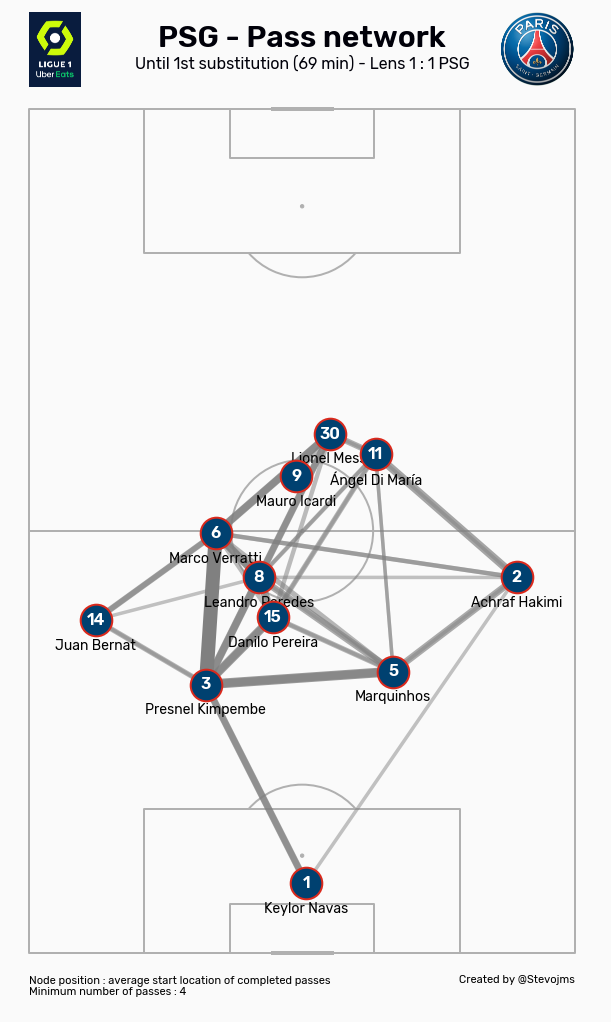

In [51]:
### Data visualisation part

#Setting up line and markers width
MAX_LINE_WIDTH = 14
MAX_MARKER_SIZE = 1500

pass_between_away['width'] = (pass_between_away.pass_count / pass_between_away.pass_count.max() * MAX_LINE_WIDTH)
average_locations_away['marker_size'] = (average_locations_away['count'] / average_locations_away['count'].max() * MAX_MARKER_SIZE)

pass_between = pass_between_away
average_locations = average_locations_away

#Setting up colors to make the line transparent when fewer passes are made

MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('grey'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY) + MIN_TRANSPARENCY)
color[:, 3] = c_transparency

#Pitch visualisation

team_color = '#004170' #Fill in the team color
node_edgecolor = '#DA291C'
number_color = '#ffffff'

bgcol = '#fafafa' 

URL = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Light.ttf?raw=true'
URL2 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Regular.ttf?raw=true'
URL3 = 'https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-SemiBold.ttf?raw=true'

rubik_light = FontManager(URL)
rubik_regular = FontManager(URL2)
rubik_semibold = FontManager(URL3)

#Change image URL if needed
COMPETITION_URL = 'https://upload.wikimedia.org/wikipedia/commons/4/49/Ligue1_Uber_Eats_logo.png'
competition_image = Image.open(urlopen(COMPETITION_URL))

#Change team logo URL if needed
team_logo_URL = 'https://logos-world.net/wp-content/uploads/2020/06/PSG-Logo.png' #Team logo
team_logo_image = Image.open(urlopen(team_logo_URL))

pitch = VerticalPitch(pitch_type= 'opta', half=False)
fig, axs = pitch.grid(figheight=14, title_height=0.08, endnote_space=0,
                      # Turn off the endnote/title axis. I usually do this after
                      # I am happy with the chart layout and text placement
                      axis=False,
                      title_space=0, grid_height=0.88, endnote_height=0.04)

fig.set_facecolor(bgcol)
axs['title'].set_facecolor(bgcol)
axs['pitch'].set_facecolor(bgcol)
axs['endnote'].set_facecolor(bgcol)

#pass_arrows = pitch.arrows(pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, lw=pass_between.width, color=color, zorder=2, ax=axs['pitch'])

pass_lines = pitch.lines(pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, lw=pass_between.width, color=color, zorder=2, ax=axs['pitch'])
pass_nodes = pitch.scatter(average_locations.x, average_locations.y, s=1000, c=team_color, linewidth = 2, edgecolors=node_edgecolor, ax=axs['pitch'], zorder = 3)

for index, row in average_locations.iterrows():
    pitch.annotate(row['passer'], xy=(row.x, row.y), c=number_color, va="center", ha="center",
                    size= 16, ax=axs['pitch'], fontproperties=rubik_semibold.prop, zorder = 4)
    pitch.annotate(row['name'], xy=(row.x - 3, row.y), c='black', va='center',
                   ha='center', size= 14, ax=axs['pitch'], fontproperties=rubik_regular.prop, zorder = 2)

    
TITLE = f'{away_team} - Pass network'
SUB_TITLE = f'Until 1st substitution ({subs_away[0]} min) - {home_team} {score} {away_team}'
axs['title'].text(0.5, 0.6, TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_semibold.prop, fontsize=30)
axs['title'].text(0.5, 0.30, SUB_TITLE, color='#000009',
                  va='center', ha='center', fontproperties=rubik_regular.prop, fontsize=16)

ax_competition = add_image(competition_image, fig,
                     # set the left, bottom and height to align with the title
                     left=axs['title'].get_position().x0,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ax_team_logo = add_image(team_logo_image, fig,
                     # set the left to align with the pitch left border
                     left=0.77,
                     bottom=axs['title'].get_position().y0,
                     height=axs['title'].get_position().height-0.005)

ENDNOTE_LEFT = 'Created by @Stevojms'
ENDNOTE_RIGHT1 = f'Node position : average start location of completed passes\nMinimum number of passes : {min_nb_passes_away}'

axs['endnote'].text(1, 1, ENDNOTE_LEFT,
                  va='top', ha='right', fontproperties=rubik_regular.prop, fontsize=11)
axs['endnote'].text(0, 1, ENDNOTE_RIGHT1,
                  va='top', ha='left', fontproperties=rubik_regular.prop, fontsize=11)

#plt.savefig(away_team + '_PassNetwork.png', dpi=800)

## Automation

In this part, we are thinking about automating the whole process. Below, you can find functions that will be used for automation purposes.

In [39]:
def get_df_passes(df_rel, side, successful):
    """
    df_rel : dataframe with relevant columns
    side : home or away
    successful : False if we want all the passes 
    """
    if side == 'home':
        df_home = df_rel[df_rel['teamId'] == home_team]
        h_passes = df_home[df_home['type'] == 'Pass']
        h_passes['shirtNo'] = h_passes['shirtNo'].astype('int64')
        h_passes['passer'] = h_passes['passer'].astype('int64')
        h_passes['recipient'] = pd.to_numeric(h_passes['recipient'], downcast = 'integer')
        
        if successful == True:
            h_passes_succ = h_passes[h_passes['outcomeType'] == 'Successful']
            return h_passes_succ
        
        return h_passes
    
    elif side == 'away':
        df_away = df_rel[df_rel['teamId'] == away_team]
        a_passes = df_away[df_away['type'] == 'Pass']
        a_passes['shirtNo'] = a_passes['shirtNo'].astype('int64')
        a_passes['passer'] = a_passes['passer'].astype('int64')
        a_passes['recipient'] = pd.to_numeric(a_passes['recipient'], downcast = 'integer')
        
        if successful == True:
            a_passes_succ = a_passes[a_passes['outcomeType'] == 'Successful']
            return a_passes_succ
        
        return a_passes

    else:
        return 'Error with parameters'
    



In [40]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,relatedEventId,relatedPlayerId,goalMouthZ,goalMouthY,isShot,blockedX,blockedY,cardType,isGoal
0,2.362774e+09,2,0,0.0,PSG,0.0,0.0,0,FirstHalf,Start,Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.362774e+09,2,0,0.0,Lens,0.0,0.0,0,FirstHalf,Start,Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.362774e+09,3,0,0.0,PSG,50.0,50.0,0,FirstHalf,Pass,Successful,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 117, 30, 35, 38, 216, 218]",True,106964.0,34.1,41.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.362774e+09,4,0,1.0,PSG,34.1,41.2,0,FirstHalf,Pass,Successful,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 117, 30, 36, 37, 216, 218]",True,93700.0,35.4,56.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.362774e+09,5,0,2.0,PSG,35.2,56.4,0,FirstHalf,Pass,Successful,"[{'type': {'value': 140, 'displayName': 'PassE...","[91, 117, 30, 35, 38, 215, 218]",True,94891.0,30.4,41.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2.362774e+09,6,0,6.0,PSG,30.8,39.8,0,FirstHalf,Pass,Successful,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 117, 30, 35, 37, 215, 218]",True,101949.0,26.7,82.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.362774e+09,7,0,8.0,PSG,27.0,85.7,0,FirstHalf,Pass,Successful,"[{'type': {'value': 178, 'displayName': 'Stand...","[91, 117, 30, 36, 37, 216, 218]",True,247800.0,37.4,93.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.362774e+09,8,0,9.0,PSG,38.2,90.9,0,FirstHalf,Pass,Successful,"[{'type': {'value': 213, 'displayName': 'Angle...","[91, 117, 30, 35, 37, 215, 218]",True,91961.0,32.1,96.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.362774e+09,9,0,11.0,PSG,30.9,95.6,0,FirstHalf,Pass,Successful,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[91, 117, 30, 35, 38, 215, 218]",True,106894.0,13.1,85.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.362774e+09,10,0,14.0,PSG,12.8,85.6,0,FirstHalf,Pass,Successful,"[{'type': {'value': 141, 'displayName': 'PassE...","[91, 117, 30, 35, 38, 215, 218]",True,247800.0,3.8,64.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
